In [1]:
%load_ext autoreload
%autoreload 2

import markovlink
import numpy as np
import numpy.random as npr
import scipy as sp
import pickle
import matplotlib.pylab as plt
import sys

%matplotlib inline

# simulation results

### simulation I

We first create a parameters we can simulate from:

In [532]:
# pick the number of populations and the number of different values that can be returned by each tool
num_ells=20
num_xs=6
num_ys=6

plx_star = np.array([npr.dirichlet(np.ones(num_xs)*npr.exponential()) for x in range(num_ells)])
qxy_star = np.array([npr.dirichlet(np.ones(num_ys)*npr.exponential()) for x in range(num_xs)])
hly_star= plx_star @qxy_star

Now we simulate data:

In [533]:
nsamps=100
Nlx=np.array([npr.multinomial(nsamps,x) for x in plx_star])
Nly=np.array([npr.multinomial(nsamps,x) for x in hly_star])

We estimate p,q,h using the MLM.  This returns an estimate for (p,q,h), along with a collection of extremal bootstrap estimates of (p,q,h)

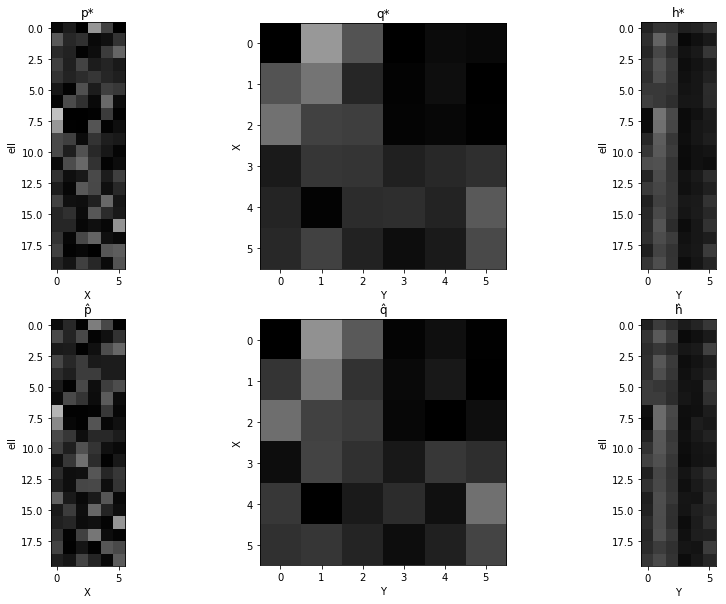

In [191]:
(phat,qhat,hhat) = markovlink.point_estimates(Nlx,Nly)

plt.gcf().set_size_inches(15,10);
plt.subplot(2,3,1); plt.imshow(plx_star,vmin=0,vmax=1,cmap='gray'); plt.xlabel("X"); plt.ylabel("ell"); plt.title('p*')
plt.subplot(2,3,2); plt.imshow(qxy_star,vmin=0,vmax=1,cmap='gray'); plt.xlabel("Y"); plt.ylabel("X"); plt.title('q*')
plt.subplot(2,3,3); plt.imshow(hly_star,vmin=0,vmax=1,cmap='gray'); plt.xlabel("Y"); plt.ylabel("ell"); plt.title('h*')

plt.subplot(2,3,4); plt.imshow(phat,vmin=0,vmax=1,cmap='gray'); plt.xlabel("X"); plt.ylabel("ell"); plt.title('p̂')
plt.subplot(2,3,5); plt.imshow(qhat,vmin=0,vmax=1,cmap='gray'); plt.xlabel("Y"); plt.ylabel("X"); plt.title('q̂')
plt.subplot(2,3,6); plt.imshow(hhat,vmin=0,vmax=1,cmap='gray'); plt.xlabel("Y"); plt.ylabel("ell"); plt.title('ĥ')
plt.savefig('images/simulation1Groundtruth.png',dpi=300,bbox_inches='tight')

How close are the estimators to the truth?

In [192]:
print("error of MLM estimator for p:\t\t",markovlink.misc.totalvardist(phat,plx_star))
print("error of MLM estimator for q:\t\t",markovlink.misc.totalvardist(qhat,qxy_star))
print("error of MLM estimator for h:\t\t",markovlink.misc.totalvardist(hhat,hly_star))

error of MLM estimator for p:		 1.608961863063879
error of MLM estimator for q:		 0.5722165875937694
error of MLM estimator for h:		 0.8387350312662037


We can also estimate h directly, using a more traditional method

In [193]:
hhat2 = markovlink.estimation.pseudocount_point_estimate(Nly)
print("error of pseudocount estimator for h:\t",markovlink.misc.totalvardist(hhat2,hly_star))

error of pseudocount estimator for h:	 1.8126272438445519


We can see that knowing that the MLM holds allows us to get a considerably better estimate for h.

Nonetheless, the MLM does have error.  This is not surprising, since the amount of data isn't infinite.  The important question is whether the MLM can accurately *quantify* its own error.  Part of this quantification is done using the bootstrap:

In [194]:
straps,deltas=markovlink.bootstrap(Nlx,Nly,phat,qhat)
print("var","\t","MLM err","\t","bootstrap vbility")
print("p\t","%.05f\t"%markovlink.misc.totalvardist(phat,plx_star),deltas[0])
print("q\t","%.05f\t"%markovlink.misc.totalvardist(qhat,qxy_star),deltas[1])
print("h\t","%.05f\t"%markovlink.misc.totalvardist(hhat,hly_star),deltas[2])

var 	 MLM err 	 bootstrap vbility
p	 1.60896	 1.6096716981132078
q	 0.57222	 0.6979966714967106
h	 0.83874	 1.0013452997231307


Note that if you run this code you may get slightly different numbers.  In some cases the error will be greater thant he bootstrap vbility, in some cases less.  The idea is that the vbility will give one a rough estimate of the estimator variance.

### simulation II

Let's repeat this experiment with fewer subpopulations.  In particular, let's see what would have happened if we took the old subpopulations and merged groups of 4 together:

In [534]:
plx_star_merged = np.mean(plx_star.reshape((num_ells//4,4,num_xs)),axis=0)
hly_star_merged= plx_star_merged @qxy_star

Nlx_merged=np.sum(Nlx.reshape((num_ells//4,4,num_xs)),axis=0)
Nly_merged=np.sum(Nly.reshape((num_ells//4,4,num_ys)),axis=0)
(phat,qhat,hhat) = markovlink.point_estimates(Nlx_merged,Nly_merged)
hhat2 = markovlink.estimation.pseudocount_point_estimate(Nly_merged)

straps,deltas=markovlink.bootstrap(Nlx_merged,Nly_merged,phat,qhat)
print("var","\t","MLM err","\t","bootstrap vbility")
print("p\t","%.05f\t"%markovlink.misc.totalvardist(phat,plx_star_merged),deltas[0])
print("q\t","%.05f\t"%markovlink.misc.totalvardist(qhat,qxy_star),deltas[1])
print("h\t","%.05f\t"%markovlink.misc.totalvardist(hhat,hly_star_merged),deltas[2])


var 	 MLM err 	 bootstrap vbility
p	 0.13171	 0.14639541501976286
q	 1.70213	 1.2665095999858278
h	 0.11697	 0.14392685722960066


We get better estimates for $p,h$, but $q$ estimation actually gets worse.  This is because of identifiability.  What's worse, the bootstrap variability doesn't even seem to faithfully represent the degree of the problem.  For this reason MLM provides an additional term which bounds the potential danger of this identifiability issue:

In [212]:
np.mean(markovlink.diameter_estimates(straps))

1.8264193103662907

This is quite conservative.  The true error is only about $1$, and this together with the bootstrap variability gives an error of as much as $3$.  It would be interesting in future work to see if a less conservative estimate of the variability could be found.

What happens if we give it a near-infinite amount of data?

In [220]:
nsamps=10**10
Nlx_merged=np.array([npr.multinomial(nsamps,x) for x in plx_star_merged])
Nly_merged=np.array([npr.multinomial(nsamps,x) for x in hly_star_merged])

In [221]:
(phat,qhat,hhat) = markovlink.point_estimates(Nlx_merged,Nly_merged)
hhat2 = markovlink.estimation.pseudocount_point_estimate(Nly_merged)

straps,deltas=markovlink.bootstrap(Nlx_merged,Nly_merged,phat,qhat)
print("var","\t","MLM err","\t","bootstrap vbility")
print("p\t","%.05e\t"%markovlink.misc.totalvardist(phat,plx_star_merged),"%.05e"%deltas[0])
print("q\t","%.05f\t"%markovlink.misc.totalvardist(qhat,qxy_star),"%.05f"%deltas[1])
print("h\t","%.05e\t"%markovlink.misc.totalvardist(hhat,hly_star_merged),"%.05e"%deltas[2])

var 	 MLM err 	 bootstrap vbility
p	 2.26252e-05	 3.43485e-05
q	 0.78515	 0.00033
h	 2.75947e-03	 3.26498e-05


In [222]:
print(np.mean(markovlink.diameter_estimates(straps)))

3.518331439055117


### simulation III

For our final simulation, we look at how well estimation of $q$ works as a function of the nature of $q$.   We will look at the case that $X,Y$ are independent, the case that $X=Y$, and everything in-between.  We will also look at different numbers of samples.

In [150]:
num_ells=4
num_xs=6
num_ys=num_xs

# convexs index the progression from independent to deterministic
convexs=np.r_[0:1:500j]

# nsamps are the different number of samples we use
nsamps=[5,50,500,5000,'infinity']

# we keep track of the error for each q and each number of samples
errs=np.zeros((len(convexs),len(nsamps),3))

# we will use the same plx throughout
plx_star = np.array([npr.dirichlet(np.ones(num_xs)*1) for x in range(num_ells)])

# q will be a convex combination between AA and BB
AA=np.eye(num_xs)
BB=np.zeros((num_xs,num_xs)); BB[:]=npr.dirichlet(np.ones(num_xs)).reshape((1,-1))

# iterate through the possible values of q
for i,conv in enumerate(convexs):
    if i%100==0:
        markovlink.misc.pnn(i)
    
    # make the q parameters as a function of conv
    qxy_star = AA*conv+(1-conv)*BB
    hly_star= plx_star @qxy_star
    
    # for each number of samples, simulate a dataset of that size, 
    # estimate q from the dataset, and report the error
    for j,nsamp in enumerate(nsamps):
        if nsamp=='infinity': 
            nsamp=1000000000000000
        Nlx=np.array([npr.multinomial(nsamp,x) for x in plx_star])
        Nly=np.array([npr.multinomial(nsamp,x) for x in hly_star])
        phat,qhat,hhat= markovlink.point_estimates(Nlx,Nly)
        errs[i,j,0]=markovlink.misc.totalvardist(phat,plx_star)
        errs[i,j,1]=markovlink.misc.totalvardist(qhat,qxy_star)
        errs[i,j,2]=markovlink.misc.totalvardist(hhat,hly_star)
    

0 100 200 300 400 

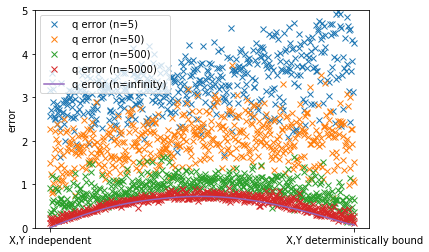

In [152]:
for j,nsamp in enumerate(nsamps):
    if nsamp=='infinity':
        plt.plot(convexs,errs[:,j,1],'-',label='q error (n=infinity)')
    else:
        plt.plot(convexs,errs[:,j,1],'x',label='q error (n=%d)'%nsamp)
plt.ylim(0,5.0)
plt.ylabel("error")
plt.xticks([0,1],['X,Y independent','X,Y deterministically bound'])
plt.legend()
plt.legend()
plt.savefig('images/estimatingq.png',dpi=300,bbox_inches='tight')

### simulation IV: permutation matrices are identifiable with very few subpopulations

In [529]:
# pick the number of populations and the number of different values that can be returned by each tool
num_ells=8
num_xs=128
num_ys=128


plx_star = np.array([npr.dirichlet(np.ones(num_xs)) for x in range(num_ells)])
qxy_star=np.eye(num_xs)

idxs=np.r_[0:num_xs]
# npr.shuffle(idxs)
qxy_star=qxy_star[idxs]

hly_star= plx_star @qxy_star

In [530]:
nsamps=4000
Nlx=np.array([npr.multinomial(nsamps,x) for x in plx_star])
Nly=np.array([npr.multinomial(nsamps,x) for x in hly_star])

(phat,qhat,hhat) = markovlink.point_estimates(Nlx,Nly)

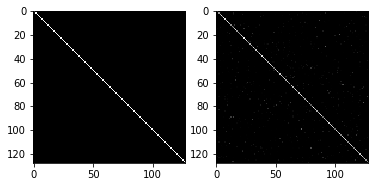

In [531]:
plt.subplot(1,2,1)
plt.imshow(qxy_star,cmap='gray',vmin=0,vmax=1)
plt.subplot(1,2,2)
plt.imshow(qhat,cmap='gray',vmin=0,vmax=1)
plt.savefig('images/miracle.png',dpi=300,bbox_inches='tight')

# allen institute results

In [251]:
# example input: two matrices, Nly and Nlx
with open('exampletables.pkl','rb') as f:
    locals().update(pickle.load(f))

Our original data comes in the form of two tables.

The first table, `Nlx`, gives the result of running technique I one some data.  This technique takes in a given specimen and returns one of a finite number of different responses, each of which tells us something different about the specimen.  In this case, these responses corresponded to guesses about the cell type of the specimens, which were cells.  In general, any measurement tool that gives one of a discrete number of responses can be used (or, if the response is continuous, we can bin responses to make them discrete).  

To be concrete: `Nlx[l,x]` gives the  the number of samples from subpopulation `l` that that measured as `x` by technique I.  We expect `Nlx` to be a numpy matrix.  

Our input data also has 
- `cre_names`, which gives the name of each subpopulation
- `facs_names`, which gives the name of each possible `x` measurement
- `patch_names`, which gives the name of each possible `y` measurement

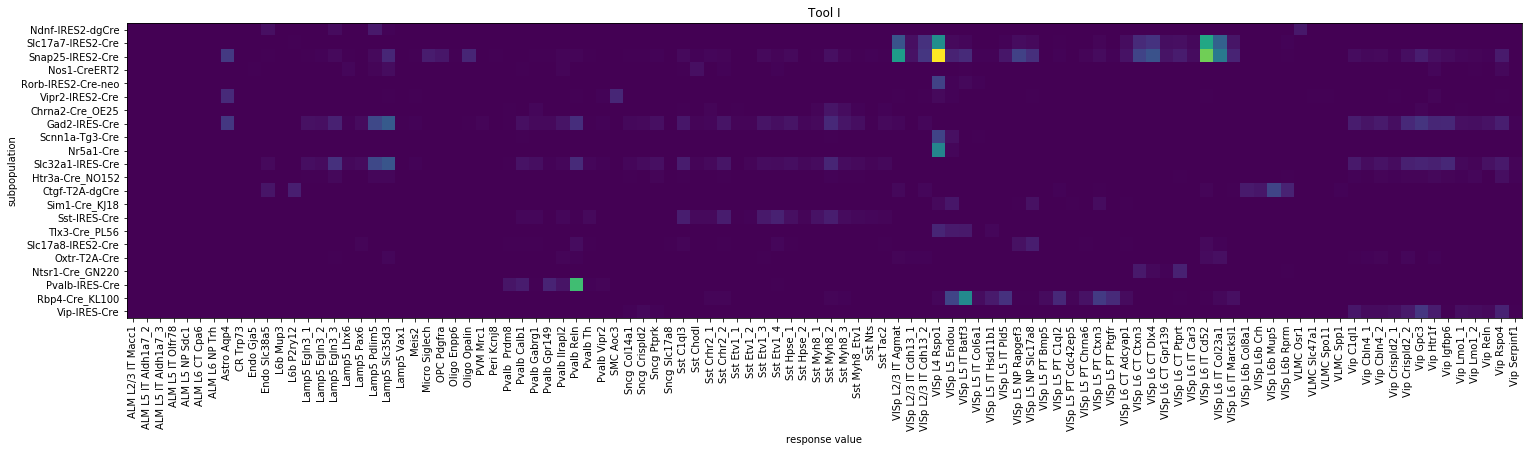

In [224]:
plt.imshow(Nlx); plt.ylabel('subpopulation'); plt.xlabel("response value");
plt.title("Tool I")
plt.gcf().set_size_inches(25,10)
plt.yticks(range(len(cre_names)),cre_names)
plt.xticks(range(len(facs_names)),facs_names,rotation='vertical')
plt.savefig("images/allenNlx.png",dpi=300,bbox_inches='tight')

The second table, `Nly`, is based on a completely different dataset, run on completely different specimens, with completely different technique.  These specimens were treated with technique II, which also returns one of a finite number of different responses.   `Nly[l,y]` gives the number of samples from subpopulation `l` that were measured as `y` by technique II.

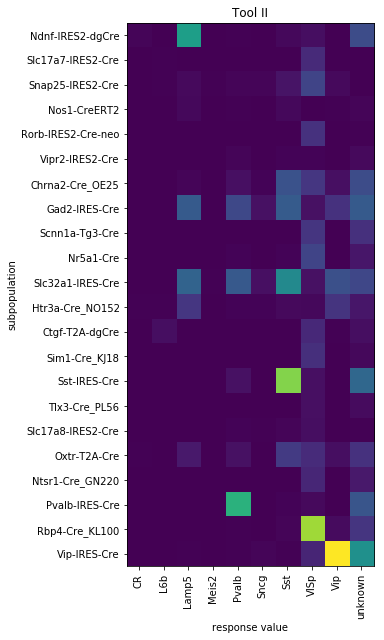

In [225]:
plt.imshow(Nly); 
plt.ylabel('subpopulation'); plt.xlabel("response value"); 
plt.title("Tool II")
plt.gcf().set_size_inches(10,10)
plt.yticks(range(len(cre_names)),cre_names)
plt.xticks(range(len(patch_names)),patch_names,rotation='vertical')
plt.savefig("images/allenNly.png",dpi=300,bbox_inches='tight')

In no case was the *same specimen* observed using both techniques.  However, both techniques sampled from the same set of subpopulations.  Using a Markov Link assumption, this enables us to determine a set of possible calibrations, or correspondences between the two methods.

### Get point estimates

In [253]:
(phat,qhat,hhat) = markovlink.point_estimates(Nlx,Nly)

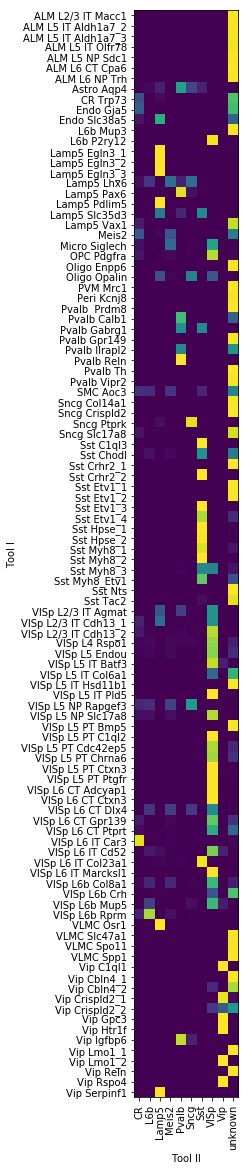

In [227]:
plt.imshow(qhat)
plt.gcf().set_size_inches(20,20)
plt.ylabel('Tool I')
plt.xlabel("Tool II")
plt.xticks(range(len(patch_names)),patch_names,rotation='vertical')
plt.yticks(range(len(facs_names)),facs_names);
plt.savefig("images/allenqhat.png",dpi=300,bbox_inches='tight')

let's look at a few select guys more numerically

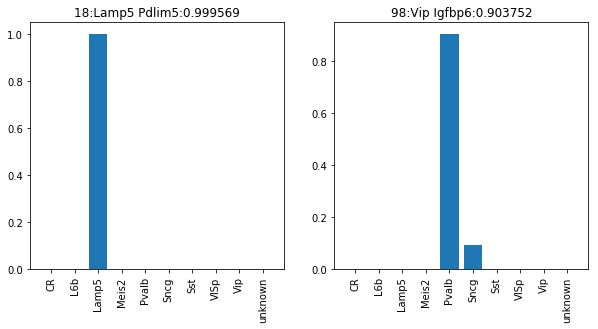

In [402]:
def go(x):
    plt.bar(np.r_[0:len(qhat[x])],qhat[x])
    plt.xticks(np.r_[0:len(qhat[x])],patch_names,rotation='vertical')
    plt.title("%d:%s:%f"%(x,facs_names[x],np.max(qhat[x])))

plt.gcf().set_size_inches(10,10)

for i,x in enumerate([18,98]):
    plt.subplot(2,2,i+1)
    go(x)

### Model criticism

We have assumed that our data can be modeled as $p(X|\ell)q(Y|X)$.  Due to the limitations of our data, it is not possible to ever be sure whether this assumption is really correct.  However, there are some limited checks we can perform, and would be be remiss if we ignored them.

One basic test would be to make sure that our model performs well on aspects of the data we *can* test.  In particular, our trained model implies a very specific distriution for $\mathbb{P}(Y=y|\ell)$, namely $h(y|\ell)\triangleq \sum_x \hat p(X|\ell)\hat q(y|x)$.  On the other hands, there are other more conventional ways of estimating the distribution of $\mathbb{P}(Y=y|\ell)$ from the data we have -- namely by using an empirical distribution.  We can compare these two methods for estimating $\mathbb{P}(Y=y|\ell)$ in terms of how well they model held-out data.

First we split data into training data and testing data:

In [159]:
print("We have",np.sum(Nly),"total samples")
holdout=10
Nly_train,Nly_test = markovlink.exploration.train_test_split(Nly,holdout)
Nlx_train,Nlx_test = markovlink.exploration.train_test_split(Nlx,holdout)
print("Now we have",np.sum(Nly_train),"samples to train p(y|l) and",np.sum(Nly_test),"samples to test on")
print("Now we have",np.sum(Nlx_train),"samples to train p(x|l) and",np.sum(Nlx_test),"samples to test on")

We have 2417.0 total samples
Now we have 2197.0 samples to train p(y|l) and 220.0 samples to test on
Now we have 10468.0 samples to train p(x|l) and 220.0 samples to test on


Train the model on just the training data

In [160]:
phat_train,qhat_train,hhat_train= markovlink.point_estimates(Nlx_train,Nly_train)

Train a simpler model on just the training data

In [162]:
hhat2 = markovlink.estimation.pseudocount_point_estimate(Nly_train)

We can then compare the two methods.  Fewer nats is better, as it indicates that our model provides a more concise representation of the new observations.  

In [163]:
lik=np.sum(np.log(hhat2)*(Nly_test)) / np.sum(Nly_test)
print("Cost of coding with traditional estimate: %.1f nats per entry"%(-lik))
lik=np.sum(np.log(hhat_train)*(Nly_test)) / np.sum(Nly_test)
print("Cost of coding with MLM estimate: %.1f nats per entry"%(-lik))

Cost of coding with traditional estimate: 1.3 nats per entry
Cost of coding with MLM estimate: 1.3 nats per entry


This is encouraging.  Our model is as good at predicting held-out data as a more traditional estimate which makes no assumptions on the structure of the data.  

### Computing $\Delta$ variability estimates

We use the bootstrap to get a rough sense for the variance of our estimators.

In [252]:
straps,deltas=markovlink.bootstrap(Nlx,Nly,phat,qhat,verbose=True)

50 bootstraps: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [179]:
print("var","\t","bootstrap vbility")
print("p\t",deltas[0])
print("q\t",deltas[1])
print("h\t",deltas[2])

var 	 bootstrap vbility
p	 6.735192229149345
q	 50.334122562312416
h	 3.680001908475479


We see we have actually quite a lot of variability in the q.

## Computing diameter

In [187]:
np.mean(markovlink.diameter_estimates(straps,verbose=True))

50 bootstraps to consider: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

18.040261764959645

## Qualitative looks

In [352]:
def make_Q1R_plot(x):
    nm=facs_names[x]
    nm=nm.replace(' ','')
    nm=nm.replace('_','')
    Q1Rs=markovlink.qualitative_one_row(straps,x,verbose=True)
    Q1Rsm=Q1Rs.reshape((-1,Q1Rs.shape[1]))

    plt.gcf().add_axes([0,.2,1,1])
    plt.pcolor(Q1Rsm)
    plt.yticks([])
    plt.xticks([])
    plt.title('q(y | x = %s)'%facs_names[x])
    plt.ylabel("plausible alternatives")

    plt.gcf().add_axes([0,0,1.0,.2])
    plt.imshow(qhat[x,None])

    plt.xticks(np.r_[0:len(patch_names)],patch_names,rotation='vertical')
    plt.yticks([])
    plt.ylabel("original\n estimate")
    plt.savefig("images/q1r%s.png"%nm,dpi=300,bbox_inches='tight')

In [ ]:
make_Q1R_plot(98)

50 bootstraps to consider: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

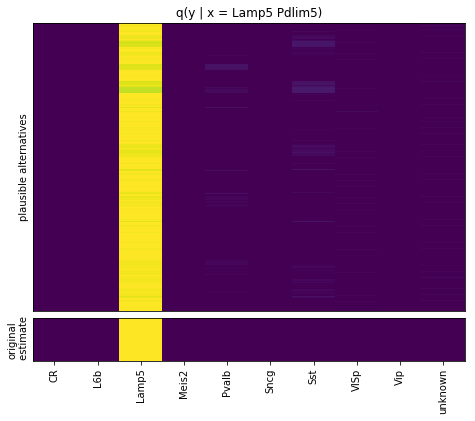

In [403]:
make_Q1R_plot(18)